In [2]:
import sqlite3
import requests
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import os
import requests
import time
from datetime import datetime, timedelta, timezone
import requests
import pandas as pd
import time


In [7]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 3.9 MB/s eta 0:00:39
   ---------------------------------------- 1.6/150.0 MB 4.7 MB/s eta 0:00:32
    --------------------------------------- 2.9/150.0 MB 5.2 MB/s eta 0:00:29
   - -------------------------------------- 4.5/150.0 MB 5.9 MB/s eta 0:00:25
   - -------------------------------------- 6.3/150.0 MB 6.5 MB/s eta 0:00:23
   -- ------------------------------------- 7.9/150.0 MB 6.6 MB/s eta 0:00:22
   -- ------------------------------------- 11.0/150.0 MB 7.8 MB/s eta 0:00:18
   --- ------------------------------------ 14.9/150.0 MB 9.2 MB/s eta 0:00:15
   ----- ---------------------------------- 18.9/150.0 MB 10.3 MB/s eta 0:00:13
   ----- ---------------------------------- 21.8/150.0 MB 10.7 MB/s eta 0:00:13
   ------ --------------------------------- 25.7/150.0 MB 11.4 MB/s eta 0:00:11
   -------- ------------------------------- 30.4/150.0 MB 12.5 


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
conn = sqlite3.connect("Database/news_data.db")

In [4]:
df = pd.read_sql_query("""
                        SELECT 
                            ticker
                        FROM Stocks
                        """, conn)

tickers = df["ticker"].values.tolist()

In [5]:
len(tickers)

23

In [6]:
def get_complete_df(tickers, future_time_offset):
    """
    Fetch and process data for the given tickers with a customizable future time offset.

    Parameters:
    - tickers: List of stock tickers.
    - future_time_offset: String representing the time offset for future price (e.g., '+1 hour', '+2 hours', '+1 day').

    Returns:
    - A DataFrame containing the processed data.
    """
    dfs_list = []
    for ticker in tickers:
        query = f"""
            SELECT 
                a.ticker,
                a.url,
                a.title,
                a.summary,
                a.source_domain,
                a.closest_time_before_published,
                datetime(a.closest_time_before_published, '{future_time_offset}') AS 'future_time',
                CASE
                    WHEN TIME(REPLACE(a.closest_time_before_published, '+00:00', ''), '{future_time_offset}') > '19:50:00'
                    THEN DATE(REPLACE(a.closest_time_before_published, '+00:00', ''), '+1 day') || ' 13:30:00'
                    ELSE DATETIME(REPLACE(a.closest_time_before_published, '+00:00', ''), '{future_time_offset}')
                END AS adjusted_future_time,
                s.open AS open_price,
                f.close AS future_price,
                a.time_published
            FROM {ticker}_NewsArticles AS a
            LEFT JOIN {ticker}PriceHistory AS s 
                ON a.closest_time_before_published = s.date
            LEFT JOIN {ticker}PriceHistory AS f 
                ON REPLACE(f.date, '+00:00', '') = adjusted_future_time
        """

        # Execute the query and fetch the data
        df = pd.read_sql_query(query, conn)
        print(f"Fetched {len(df)} rows for ticker: {ticker}")
        dfs_list.append(df)

    # Combine all dataframes into one
    complete_df = pd.DataFrame()
    for df in dfs_list:
        if not df.empty:
            df = df.drop_duplicates(subset=["summary", "title"])
            complete_df = pd.concat([complete_df, df], ignore_index=True)

    # Drop rows with missing values
    complete_df = complete_df.dropna()

    print(f"Final DataFrame columns: {complete_df.columns}")
    print(f"Total rows in complete DataFrame: {len(complete_df)}")

    return complete_df

In [ ]:
dfs_list = []
for ticker in tickers:
    query = f"""
            SELECT 
                a.ticker,
                a.url,
                a.title,
                a.summary,
                a.source_domain,
                a.closest_time_before_published,
                datetime(a.closest_time_before_published, '1+ hour') AS 'future_time',
                CASE
                    WHEN TIME(REPLACE(a.closest_time_before_published, '+00:00', ''), '1+ hour') > '19:50:00'
                    THEN DATE(REPLACE(a.closest_time_before_published, '+00:00', ''), '+1 day') || ' 13:30:00'
                    ELSE DATETIME(REPLACE(a.closest_time_before_published, '+00:00', ''), '1+ hour')
                END AS adjusted_future_time,
                s.open AS open_price,
                f.close AS future_price,
                a.time_published
            FROM {ticker}_NewsArticles AS a
            LEFT JOIN {ticker}PriceHistory AS s 
                ON a.closest_time_before_published = s.date
            LEFT JOIN {ticker}PriceHistory AS f 
                ON REPLACE(f.date, '+00:00', '') = adjusted_future_time
        """

    # Execute the query and fetch the data
    df = pd.read_sql_query(query, conn)
    print(f"Fetched {len(df)} rows for ticker: {ticker}")
    dfs_list.append(df)


final_df = pd.DataFrame()

for df in dfs_list:
    if not df.empty:
        ticker = df["ticker"][0]
        grouped = df.groupby('source_domain').size().reset_index(name=f'{ticker}_frequency')
        final_df = pd.concat([final_df, grouped], ignore_index=True)


"final_df = final_df.groupby('source_domain').sum().reset_index()\nprint(final_df.sort_values(by='frequency', ascending=False))"

In [34]:
final_df["sum_frequency"] = final_df.filter(like='_frequency').sum(axis=1)

In [42]:
grouped_final_df = final_df.groupby('source_domain').sum(numeric_only=True).reset_index()

In [45]:
len(grouped_final_df)

52

In [5]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 10000)

In [62]:

grouped_final_df[grouped_final_df["sum_frequency"] > 500].sort_values(by='sum_frequency', ascending=False)

,source_domain,AAPL_frequency,MSFT_frequency,NVDA_frequency,BAC_frequency,GS_frequency,PLD_frequency,O_frequency,SPG_frequency,XOM_frequency,CVX_frequency,SLB_frequency,AMZN_frequency,WMT_frequency,TGT_frequency,KO_frequency,PG_frequency,PEP_frequency,JNJ_frequency,PFE_frequency,NFLX_frequency,DIS_frequency,sum_frequency
23,www.benzinga.com,697.0,406.0,321.0,296.0,503.0,85.0,78.0,134.0,552.0,545.0,531.0,332.0,465.0,405.0,259.0,284.0,412.0,436.0,443.0,384.0,488.0,8056.0
51,www.zacks.com,345.0,263.0,257.0,138.0,116.0,217.0,267.0,397.0,1064.0,1137.0,871.0,340.0,127.0,544.0,305.0,340.0,238.0,336.0,244.0,234.0,145.0,7925.0
33,www.fool.com,360.0,260.0,426.0,417.0,196.0,199.0,855.0,98.0,600.0,855.0,24.0,618.0,274.0,280.0,516.0,302.0,399.0,208.0,285.0,242.0,59.0,7473.0
39,www.investors.com,98.0,36.0,77.0,18.0,22.0,5.0,2.0,18.0,52.0,130.0,158.0,60.0,16.0,42.0,20.0,45.0,12.0,25.0,9.0,26.0,3.0,874.0
27,www.cnbc.com,11.0,55.0,88.0,121.0,65.0,2.0,5.0,36.0,84.0,6.0,34.0,11.0,61.0,9.0,23.0,51.0,41.0,37.0,50.0,33.0,21.0,844.0
37,www.globenewswire.com,0.0,30.0,10.0,39.0,52.0,6.0,0.0,10.0,96.0,10.0,84.0,1.0,24.0,3.0,44.0,40.0,34.0,117.0,140.0,36.0,19.0,795.0
34,www.forbes.com,10.0,53.0,40.0,18.0,20.0,12.0,3.0,32.0,72.0,24.0,14.0,2.0,47.0,11.0,44.0,31.0,36.0,38.0,31.0,176.0,52.0,766.0
45,www.prnewswire.com,2.0,29.0,11.0,16.0,15.0,20.0,35.0,20.0,40.0,20.0,34.0,0.0,26.0,15.0,34.0,61.0,69.0,53.0,59.0,15.0,75.0,649.0


In [64]:
grouped_final_df[grouped_final_df["sum_frequency"] > 500].sort_values(by='sum_frequency', ascending=False)[["source_domain","sum_frequency"]]

,source_domain,sum_frequency
23,www.benzinga.com,8056.0
51,www.zacks.com,7925.0
33,www.fool.com,7473.0
39,www.investors.com,874.0
27,www.cnbc.com,844.0
37,www.globenewswire.com,795.0
34,www.forbes.com,766.0
45,www.prnewswire.com,649.0


Model testing

In [25]:
complete_df = get_complete_df(tickers, '+1 hour')

Fetched 1680 rows for ticker: AAPL
Fetched 1371 rows for ticker: MSFT
Fetched 1375 rows for ticker: NVDA
Fetched 0 rows for ticker: JPM
Fetched 1412 rows for ticker: BAC
Fetched 1376 rows for ticker: GS
Fetched 606 rows for ticker: PLD
Fetched 1285 rows for ticker: O
Fetched 811 rows for ticker: SPG
Fetched 2822 rows for ticker: XOM
Fetched 2851 rows for ticker: CVX
Fetched 1908 rows for ticker: SLB
Fetched 1395 rows for ticker: AMZN
Fetched 1395 rows for ticker: WMT
Fetched 1429 rows for ticker: TGT
Fetched 1411 rows for ticker: KO
Fetched 1384 rows for ticker: PG
Fetched 1417 rows for ticker: PEP
Fetched 1343 rows for ticker: JNJ
Fetched 1385 rows for ticker: PFE
Fetched 1437 rows for ticker: NFLX
Fetched 1170 rows for ticker: DIS
Fetched 0 rows for ticker: CMCSA
Final DataFrame columns: Index(['ticker', 'url', 'title', 'summary', 'source_domain',
       'closest_time_before_published', 'future_time', 'adjusted_future_time',
       'open_price', 'future_price', 'time_published'],
   

In [29]:
complete_df.tail()

,ticker,url,title,summary,source_domain,closest_time_before_published,future_time,adjusted_future_time,open_price,future_price,time_published
26382,DIS,https://www.fool.com/earnings/call-transcripts...,Lindblad Expeditions ( LIND ) Q3 2024 Earnin...,LIND earnings call for the period ending Septe...,www.fool.com,2024-11-05 18:40:00+00:00,2024-11-05 19:40:00,2024-11-05 19:40:00,96.530,96.460,20241105T184517
26384,DIS,https://www.fool.com/earnings/call-transcripts...,fuboTV ( FUBO ) Q1 2024 Earnings Call Transc...,FUBO earnings call for the period ending March...,www.fool.com,2024-05-03 16:00:00+00:00,2024-05-03 17:00:00,2024-05-03 17:00:00,113.235,113.525,20240503T160016
26385,DIS,https://www.fool.com/investing/2024/10/21/the-...,The Semiconductor Stories of TSMC & ASML,"We also check in with Bob Stark, author of ""Th...",www.fool.com,2024-10-21 15:50:00+00:00,2024-10-21 16:50:00,2024-10-21 16:50:00,96.425,96.290,20241021T155200
26386,DIS,https://www.fool.com/earnings/call-transcripts...,Coca-Cola ( KO ) Q2 2024 Earnings Call Trans...,KO earnings call for the period ending June 30...,www.fool.com,2024-07-23 17:10:00+00:00,2024-07-23 18:10:00,2024-07-23 18:10:00,90.860,91.340,20240723T171520
26387,DIS,https://www.forbes.com/sites/sethmatlins/2024/...,The 2024 Forbes World's Most Influential CMOs ...,The 12th annual Forbes World's Most Influentia...,www.forbes.com,2024-06-19 19:50:00+00:00,2024-06-19 20:50:00,2024-06-20 13:30:00,101.490,100.850,20240620T103000


Tests

In [57]:
price_dfs = []
for ticker in tickers:
    query_price = f"""
            SELECT *
            FROM {ticker}PriceHistory 
        """

    # Execute the query and fetch the data
    price_df = pd.read_sql_query(query_price, conn)
    print(f"Fetched {len(price_df)} rows for ticker: {ticker}")
    price_dfs.append(price_df)

final_price_df = pd.DataFrame()

for df in price_dfs:
    if not df.empty:
        final_price_df = pd.concat([final_price_df, df], ignore_index=True)

print(len(final_price_df))

Fetched 20321 rows for ticker: AAPL
Fetched 20280 rows for ticker: MSFT
Fetched 20280 rows for ticker: NVDA
Fetched 20284 rows for ticker: JPM
Fetched 20284 rows for ticker: BAC
Fetched 20284 rows for ticker: GS
Fetched 20290 rows for ticker: PLD
Fetched 20290 rows for ticker: O
Fetched 20290 rows for ticker: SPG
Fetched 20301 rows for ticker: XOM
Fetched 20301 rows for ticker: CVX
Fetched 20301 rows for ticker: SLB
Fetched 20313 rows for ticker: AMZN
Fetched 20313 rows for ticker: WMT
Fetched 20313 rows for ticker: TGT
Fetched 20319 rows for ticker: KO
Fetched 20291 rows for ticker: PG
Fetched 20291 rows for ticker: PEP
Fetched 20280 rows for ticker: JNJ
Fetched 20280 rows for ticker: PFE
Fetched 20280 rows for ticker: NFLX
Fetched 20280 rows for ticker: DIS
Fetched 20280 rows for ticker: CMCSA
466746


In [71]:
final_price_df['date'] = pd.to_datetime(final_price_df['date'])
final_price_df.set_index('date', inplace=True)
final_price_df.sort_index(inplace=True)


In [46]:
news_release_df = complete_df[["closest_time_before_published","ticker"]]  # datetime of the news release
news_release_df['closest_time_before_published'] = pd.to_datetime(news_release_df['closest_time_before_published'])

C:\Users\andre\AppData\Local\Temp\ipykernel_29948\1510186416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_release_df['closest_time_before_published'] = pd.to_datetime(news_release_df['closest_time_before_published'])


In [59]:
news_release_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15891 entries, 0 to 26387
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   closest_time_before_published  15891 non-null  datetime64[ns, UTC]
 1   ticker                         15891 non-null  object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 888.5+ KB


In [60]:
final_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466746 entries, 0 to 466745
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype              
---  ------  --------------   -----              
 0   id      466746 non-null  int64              
 1   date    466746 non-null  datetime64[ns, UTC]
 2   open    466746 non-null  float64            
 3   high    466746 non-null  float64            
 4   low     466746 non-null  float64            
 5   close   466746 non-null  float64            
 6   volume  466746 non-null  int64              
 7   ticker  466746 non-null  object             
 8   sector  466746 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(2), object(2)
memory usage: 32.0+ MB


In [81]:
for i, row in news_release_df.iterrows():
    ticker = row['ticker']
    news_time = row['closest_time_before_published']

print(f"Ticker: {ticker}, News Time: {news_time}")

Ticker: DIS, News Time: 2024-06-19 19:50:00+00:00


In [84]:
print(final_price_df[(final_price_df['ticker'] == ticker)].loc[news_time]['close'])
one_hour = pd.Timedelta('1H')
try:
    print(final_price_df[(final_price_df['ticker'] == ticker)].loc[news_time + one_hour]['close'])
except KeyError:
    # If exact timestamp is missing, try the next available row after news_time + one_hour
    df_ticker = final_price_df[(final_price_df['ticker'] == ticker)]
    # Get all timestamps greater than news_time + one_hour
    next_times = df_ticker.index[df_ticker.index > news_time + one_hour]
    if len(next_times) > 0:
        next_time = next_times[0]
        print(f"Using next available time: {next_time}")
        print(df_ticker.loc[next_time]['close'])
    else:
        print("No available price after news_time + one_hour")

101.49
Using next available time: 2024-06-20 13:30:00+00:00
100.85


C:\Users\andre\AppData\Local\Temp\ipykernel_29948\1310418159.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  one_hour = pd.Timedelta('1H')


In [101]:
def compute_news_impact(news_df, price_df, timeframe='1h'):
    one_hour = pd.Timedelta(timeframe)
    news_moves = []

    for i, row in news_df.iterrows():
        ticker = row['ticker']
        news_time = row['closest_time_before_published']
        # Get price at release and one hour later
        try:
            price_at_release = price_df[(price_df['ticker'] == ticker)].loc[news_time]['close']
            try:
                price_1h_later = price_df[(price_df['ticker'] == ticker)].loc[news_time + one_hour]['close']
            except KeyError:
                # If exact timestamp is missing, try the next available row after news_time + one_hour
                df_ticker = price_df[(price_df['ticker'] == ticker)]
                # Get all timestamps greater than news_time + one_hour
                next_times = df_ticker.index[df_ticker.index > news_time + one_hour]
                if len(next_times) > 0:
                    next_time = next_times[0]
                    price_1h_later = df_ticker.loc[next_time]['close']
                else:
                    print(f"No available price after {news_time + one_hour} for ticker {ticker}")
                    continue
            
            ret = (price_1h_later - price_at_release) / price_at_release
            news_moves.append(ret)
            if len(news_moves) % 1000 == 0 or len(news_moves) == 1:
                print(f"len news_moves: {len(news_moves)}")
                print(f"Ticker: {ticker}, News Time: {news_time}")
        except KeyError:
            # Missing price data for exact timestamp
            continue

    return np.array(news_moves)


In [102]:
def compute_random_impact(price_df, news_count, timeframe='1h'):
    one_hour = pd.Timedelta(timeframe)
    random_moves = []

    tickers = price_df['ticker'].unique()

    for _ in range(news_count):
        ticker = np.random.choice(tickers)
        df = price_df[price_df['ticker'] == ticker]
        time = np.random.choice(df.index[:-6])  # exclude tail to ensure 1h data exists

        try:
            price_now = df.loc[time]['close']
            price_later = df.loc[time + one_hour]['close']
            ret = (price_later - price_now) / price_now
            random_moves.append(ret)
        except KeyError:
            continue

    return np.array(random_moves)


In [97]:
news_returns = compute_news_impact(news_release_df, final_price_df)
random_returns = compute_random_impact(final_price_df, len(news_returns))

C:\Users\andre\AppData\Local\Temp\ipykernel_29948\417737296.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  one_hour = pd.Timedelta('1H')


len news_moves: 1
Ticker: AAPL, News Time: 2023-05-02 18:20:00+00:00
len news_moves: 1000
Ticker: AAPL, News Time: 2025-03-31 19:50:00+00:00
len news_moves: 2000
Ticker: MSFT, News Time: 2025-04-22 19:50:00+00:00
len news_moves: 3000
Ticker: NVDA, News Time: 2025-04-16 19:00:00+00:00
len news_moves: 4000
Ticker: BAC, News Time: 2025-04-03 19:50:00+00:00
len news_moves: 5000
Ticker: GS, News Time: 2025-04-01 14:40:00+00:00
len news_moves: 6000
Ticker: O, News Time: 2024-05-17 14:00:00+00:00
len news_moves: 7000
Ticker: XOM, News Time: 2024-10-29 19:50:00+00:00
len news_moves: 8000
Ticker: SLB, News Time: 2024-10-21 18:40:00+00:00
len news_moves: 9000
Ticker: AMZN, News Time: 2025-04-09 19:50:00+00:00
len news_moves: 10000
Ticker: WMT, News Time: 2025-04-18 17:00:00+00:00
len news_moves: 11000
Ticker: TGT, News Time: 2025-04-09 13:40:00+00:00
len news_moves: 12000
Ticker: PG, News Time: 2024-06-25 13:30:00+00:00
len news_moves: 13000
Ticker: PEP, News Time: 2024-10-01 19:50:00+00:00
len 

C:\Users\andre\AppData\Local\Temp\ipykernel_29948\3534626435.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  one_hour = pd.Timedelta('1H')


In [98]:
print(f"Mean return after news: {news_returns.mean():.4f}")
print(f"Mean return at random: {random_returns.mean():.4f}")

Mean return after news: -0.0001
Mean return at random: -0.0000


Mean return after news: -0.0001
Mean return at random: -0.0000
T-test p-value: 0.5560


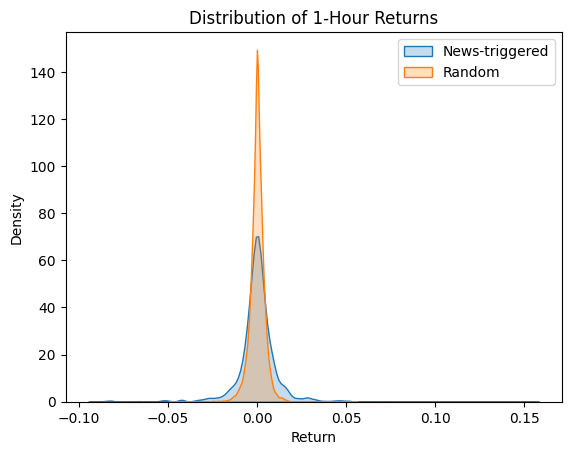

In [100]:


# Compare means
print(f"Mean return after news: {news_returns.mean():.4f}")
print(f"Mean return at random: {random_returns.mean():.4f}")

# T-test
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(news_returns, random_returns)
print(f"T-test p-value: {p_val:.4f}")

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(news_returns, label='News-triggered', fill=True)
sns.kdeplot(random_returns, label='Random', fill=True)
plt.title("Distribution of 1-Hour Returns")
plt.xlabel("Return")
plt.legend()
plt.show()


In [ ]:
timeframes = ['10min', '30min', '1h', '5h', '1d']
t_tests = []
news_returns_list = []
random_returns_list = []
for timeframe in timeframes:
    print(f"Processing timeframe: {timeframe}")
    news_returns = compute_news_impact(news_release_df, final_price_df, timeframe)
    random_returns = compute_random_impact(final_price_df, len(news_returns), timeframe)
    
    print(f"Timeframe: {timeframe}")
    print(f"Mean return after news: {news_returns.mean():.4f}")
    print(f"Mean return at random: {random_returns.mean():.4f}")
    t_stat, p_val = ttest_ind(news_returns, random_returns)
    print(f"T-test p-value: {p_val:.4f}")
    t_tests.append(p_val)
    news_returns_list.append(news_returns)
    random_returns_list.append(random_returns)


Processing timeframe: 10min
len news_moves: 1
Ticker: AAPL, News Time: 2023-05-02 18:20:00+00:00
len news_moves: 1000
Ticker: AAPL, News Time: 2025-03-31 19:50:00+00:00
len news_moves: 2000
Ticker: MSFT, News Time: 2025-04-22 19:50:00+00:00
len news_moves: 3000
Ticker: NVDA, News Time: 2025-04-16 19:00:00+00:00
len news_moves: 4000
Ticker: BAC, News Time: 2025-04-03 19:50:00+00:00
len news_moves: 5000
Ticker: GS, News Time: 2025-04-01 14:40:00+00:00
len news_moves: 6000
Ticker: O, News Time: 2024-05-17 14:00:00+00:00
len news_moves: 7000
Ticker: XOM, News Time: 2024-10-29 19:50:00+00:00
len news_moves: 8000
Ticker: SLB, News Time: 2024-10-21 18:40:00+00:00
len news_moves: 9000
Ticker: AMZN, News Time: 2025-04-09 19:50:00+00:00
len news_moves: 10000
Ticker: WMT, News Time: 2025-04-18 17:00:00+00:00
len news_moves: 11000
Ticker: TGT, News Time: 2025-04-09 13:40:00+00:00
len news_moves: 12000
Ticker: PG, News Time: 2024-06-25 13:30:00+00:00
len news_moves: 13000
Ticker: PEP, News Time: 20

In [130]:
# adding 1h to the list

timeframe = '1h'
timeframes.append(timeframe)

print(f"Processing timeframe: {timeframe}")
news_returns = compute_news_impact(news_release_df, final_price_df, timeframe)
random_returns = compute_random_impact(final_price_df, len(news_returns), timeframe)
print(f"Timeframe: {timeframe}")
print(f"Mean return after news: {news_returns.mean():.4f}")
print(f"Mean return at random: {random_returns.mean():.4f}")
t_stat, p_val = ttest_ind(news_returns, random_returns)
print(f"T-test p-value: {p_val:.4f}")
t_tests.append(p_val)
news_returns_list.append(news_returns)
random_returns_list.append(random_returns)

Processing timeframe: 1h
len news_moves: 1
Ticker: AAPL, News Time: 2023-05-02 18:20:00+00:00
len news_moves: 1000
Ticker: AAPL, News Time: 2025-03-31 19:50:00+00:00
len news_moves: 2000
Ticker: MSFT, News Time: 2025-04-22 19:50:00+00:00
len news_moves: 3000
Ticker: NVDA, News Time: 2025-04-16 19:00:00+00:00
len news_moves: 4000
Ticker: BAC, News Time: 2025-04-03 19:50:00+00:00
len news_moves: 5000
Ticker: GS, News Time: 2025-04-01 14:40:00+00:00
len news_moves: 6000
Ticker: O, News Time: 2024-05-17 14:00:00+00:00
len news_moves: 7000
Ticker: XOM, News Time: 2024-10-29 19:50:00+00:00
len news_moves: 8000
Ticker: SLB, News Time: 2024-10-21 18:40:00+00:00
len news_moves: 9000
Ticker: AMZN, News Time: 2025-04-09 19:50:00+00:00
len news_moves: 10000
Ticker: WMT, News Time: 2025-04-18 17:00:00+00:00
len news_moves: 11000
Ticker: TGT, News Time: 2025-04-09 13:40:00+00:00
len news_moves: 12000
Ticker: PG, News Time: 2024-06-25 13:30:00+00:00
len news_moves: 13000
Ticker: PEP, News Time: 2024-

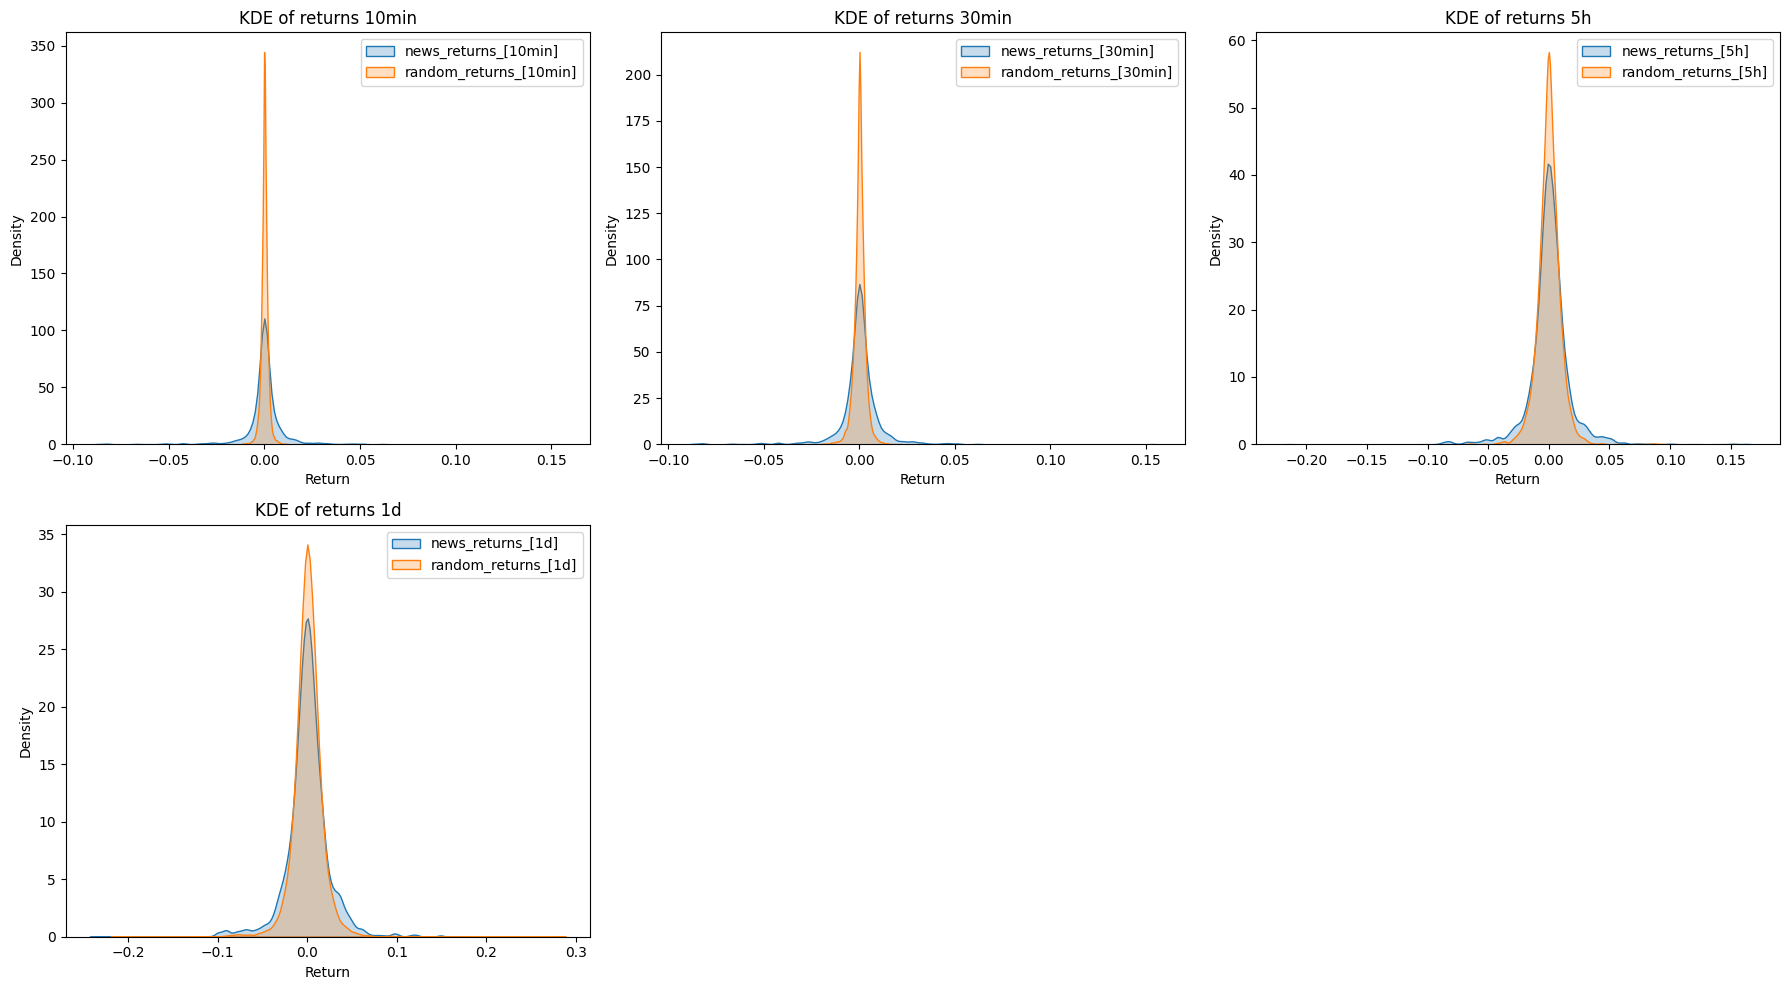

In [124]:
import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
for i in range(5):
    ax = plt.subplot(2, 3, i+1)
    if i < len(news_returns_list):
        sns.kdeplot(news_returns_list[i], label=f'news_returns_[{timeframes[i]}]', fill=True, ax=ax)
        sns.kdeplot(random_returns_list[i], label=f'random_returns_[{timeframes[i]}]', fill=True)
        ax.set_title(f'KDE of returns {timeframes[i]}')
        ax.set_xlabel('Return')
        ax.legend()
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

In [127]:
from scipy.stats import levene

for i, timeframe in enumerate(timeframes):
    print(f"Timeframe: {timeframe}")
    print(f"Mean return after news: {news_returns_list[i].mean():.5f}")
    print(f"Mean return at random: {random_returns_list[i].mean():.5f}")
    print(f"Std return for news: {np.std(news_returns_list[i]):.5f}")
    print(f"Std return for random: {np.std(random_returns_list[i]):.5f}")
    print(f"T-test p-value: {t_tests[i]:.5f}")
    stat, p = levene(news_returns_list[i], random_returns_list[i], center='median')
    print(f"Levene’s test p-value: {p}")

Timeframe: 10min
Mean return after news: -0.00009
Mean return at random: 0.00001
Std return for news: 0.01116
Std return for random: 0.00198
T-test p-value: 0.28544
Levene’s test p-value: 0.0
Timeframe: 30min
Mean return after news: -0.00003
Mean return at random: -0.00006
Std return for news: 0.01161
Std return for random: 0.00325
T-test p-value: 0.75759
Levene’s test p-value: 0.0
Timeframe: 5h
Mean return after news: 0.00033
Mean return at random: -0.00009
Std return for news: 0.01748
Std return for random: 0.00977
T-test p-value: 0.15263
Levene’s test p-value: 1.2261258972073022e-67
Timeframe: 1d
Mean return after news: 0.00015
Mean return at random: 0.00036
Std return for news: 0.02471
Std return for random: 0.01727
T-test p-value: 0.42685
Levene’s test p-value: 2.7835656845035098e-123


models

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.preprocessing import LabelEncoder



In [ ]:

# Download necessary NLTK resources
from sklearn.metrics import f1_score, precision_score, recall_score


nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

class MarketSentiment:
    def __init__(self):
        self.news_data = None
        self.price_data = None
        self.labeled_data = None
        self.model = None
        self.vectorizer = None
        self.important_features = None    



    def preprocess_data(self, df, method='tfidf', max_features=3000, ngram_range=(1, 2), use_lemmatization=True, threshold=0.001):
        """
        Preprocess the raw data to prepare for training
        """
        print("Preprocessing data...")
        lemmatizer = WordNetLemmatizer() if use_lemmatization else None
        
        # Get English stopwords
        stop_words = set(stopwords.words('english'))
        
        # Add financial terms that are too common to be useful
        financial_stopwords = {'stock', 'stocks', 'market', 'markets', 'company', 
                              'share', 'shares', 'price', 'prices', 'investor', 
                              'investors', 'trading', 'trader', 'traders', 'report',
                              'reports', 'reported', 'quarter', 'quarterly', 'fiscal',
                              'financial', 'earnings', 'revenue', 'revenues'}
        stop_words.update(financial_stopwords)
        # Combine title and summary
        df.loc[:, 'text'] = df['title'].fillna('') + ' ' + df['summary'].fillna('')

        # Compute future return (simple price delta or percentage)
        df.loc[:, 'future_return'] = (df['future_price'] - df['open_price']) / df['open_price']

        def clean_text(text):
            if not isinstance(text, str):
                return ""
                
            # Convert to lowercase
            text = text.lower()
            
            # Remove special characters and numbers
            text = re.sub(r'[^\w\s]', ' ', text)
            text = re.sub(r'\d+', ' ', text)
            
            # Tokenize
            tokens = word_tokenize(text)
            
            # Remove stopwords and lemmatize if required
            if use_lemmatization:
                cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
            else:
                cleaned_tokens = [token for token in tokens if token not in stop_words]
                
            # Join tokens back into text
            return ' '.join(cleaned_tokens)
        
        def label_sentiment(return_value, threshold=threshold):
            if return_value > threshold:
                return 'positive'
            elif return_value < -threshold:
                return 'negative'
            else:
                return 'neutral'



        # Store the labeled data
        self.labeled_data = df

        print("Preprocessing text data...")

        self.labeled_data.loc[:, 'cleaned_text'] = self.labeled_data['text'].apply(clean_text)
        
        self.labeled_data.loc[:, 'sentiment_label'] = self.labeled_data['future_return'].apply(label_sentiment)

        
        self.label_encoder = LabelEncoder()
        self.labeled_data['encoded_target'] = self.label_encoder.fit_transform(self.labeled_data['sentiment_label'])

        # Remove empty texts
        self.labeled_data = self.labeled_data[self.labeled_data['cleaned_text'].str.strip() != '']
        print(f"After preprocessing: {len(self.labeled_data)} articles")

        if method == 'count':
            self.vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
        else:  # default to tfidf
            self.vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
        # Vectorize text
        X = self.vectorizer.fit_transform(self.labeled_data['cleaned_text'])

        # Convert sparse matrix to DataFrame
        X_df = pd.DataFrame(X.toarray(), columns=self.vectorizer.get_feature_names_out())

        return X_df, self.labeled_data, self.label_encoder

    def build_model(self, X_df, target='encoded_target', test_size=0.2, random_state=42):
        """
        Build and evaluate models (Linear, Random Forest, GPU XGBoost RF)
        """
        if self.labeled_data is None or X_df is None:
            print("No data available for model building")
            return

        if target not in self.labeled_data.columns:
            print(f"Target column '{target}' not found in data")
            return

        print(f"Building models to predict {target}...")

        y = self.labeled_data[target].values
        X_train, X_test, y_train, y_test = train_test_split(
            X_df, y, test_size=test_size, random_state=random_state
        )
        self.X_train = X_train

        print(f"Training set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")


        models = {
            'Logistic Regression': LogisticRegression(),
            'XGBoost Classifier': XGBClassifier(
                        n_estimators=100,
                        learning_rate=1,
                        max_depth=10,
                        subsample=0.8,
                        colsample_bynode=0.8,
                        tree_method='hist',
                        device='cuda',
                        verbosity=1
                    )
        }

        results = {}

        # Train sklearn models
        for name, model in models.items():
            if name == "XGBoost Classifier":
                try:
                    print("Training XGBoost Classifier")

                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    class_report = classification_report(y_test, y_pred)
                    acc = accuracy_score(y_test, np.round(y_pred))
                    prec = precision_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
                    rec = recall_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
                    f1 = f1_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
                    print(f"{name} - Accuracy: {acc:.4f}")
                    print(classification_report(y_test, y_pred))

                    # For multiclass ROC/AUC, use probability estimates and specify multi_class
                    if hasattr(model, "predict_proba"):
                        y_proba = model.predict_proba(X_test)
                        auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
                    else:
                        auc = None

                    print(class_report)
                    print("acc:",acc)
                    print("prec:",prec)
                    print("rec:",rec)
                    print("f1:",f1)
                    print("auc:", auc)

                    results['XGBoost Classifier'] = {
                        'model': model,
                        'class_report': class_report,
                        'accuracy': acc,
                        'precision': prec,
                        'recall': rec,
                        'auc': auc,
                        'confusion_matrix': confusion_matrix(y_test, np.round(y_pred)),
                        'y_test': y_test,
                        'y_pred': y_pred,
                        'labelencoder': self.label_encoder
                    }
                except Exception as e:
                    print("XGBoost Classifier training failed:", e)
            else:
                print(f"Training {name}...")
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                class_report = classification_report(y_test, y_pred)
                acc = accuracy_score(y_test, np.round(y_pred))
                prec = precision_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
                rec = recall_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
                f1 = f1_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
                print(f"{name} - Accuracy: {acc:.4f}")
                print(classification_report(y_test, y_pred))

                # For multiclass ROC/AUC, use probability estimates and specify multi_class
                if hasattr(model, "predict_proba"):
                    y_proba = model.predict_proba(X_test)
                    auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
                else:
                    auc = None

                print(class_report)
                print("acc:",acc)
                print("prec:",prec)
                print("rec:",rec)
                print("f1:",f1)
                print("auc:", auc)
                
                results[name] = {
                        'model': model,
                        'class_report': class_report,
                        'accuracy': acc,
                        'precision': prec,
                        'recall': rec,
                        'auc': auc,
                        'confusion_matrix': confusion_matrix(y_test, np.round(y_pred)),
                        'y_test': y_test,
                        'y_pred': y_pred,
                        'labelencoder': self.label_encoder
                    }
        
        # Select best model
        best_model_name = max(results, key=lambda k: results[k]['accuracy'])
        self.model = results[best_model_name]['model']
        print(f"Best model: {best_model_name} with accuracy = {results[best_model_name]['accuracy']:.4f}")

        # Extract features only if supported
        if best_model_name in ['Logistic Regression', 'XGBoost Classifier']:
            self.extract_important_features(X_df.columns, best_model_name, self.model)

        return results

    
    def extract_important_features(self, model_name, model):
        """
        Extract and visualize important features from the model using SHAP
        """
        print("Extracting important features with SHAP...")

        self.feature_names = self.vectorizer.get_feature_names_out()
        try:
            explainer = shap.Explainer(model, self.X_train)
            shap_values = explainer(self.X_train)

            if shap_values.values.ndim == 3:
                # shape: (n_samples, n_classes, n_features)
                self.mean_shap = (shap_values.values).mean(axis=(0, 2))
                self.abs_mean_shap = np.abs(shap_values.values).mean(axis=(0, 2))
            else:
                # Binary classification or regression
                self.mean_shap = (shap_values.values).mean(axis=0)
                self.abs_mean_shap = np.abs(shap_values.values).mean(axis=0)
            
            # Ensure feature_names matches mean_shap length
            if len(self.mean_shap) != len(self.feature_names):
                print(f"Feature length mismatch: {len(self.feature_names)} features vs {len(self.mean_shap)} SHAP values")
                return None

            # Create DataFrame
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': self.mean_shap
            }).sort_values(by='importance', ascending=False)

            self.important_features = feature_importance.head(30)

            print("Top 10 most important features (by SHAP):")
            print(self.important_features.head(10))

            return self.important_features

        except Exception as e:
            print(f"SHAP extraction failed for {model_name}: {e}")
            return None



    def visualize_results(self, results, target='encoded_target'):
        """
        Create visualizations of model performance (regression or classification)
        and top feature importances.
        """
        if results is None or self.important_features is None:
            print("No results or feature importance to visualize")
            return

        plt.style.use('seaborn-v0_8-darkgrid')

        num_models = len(results)
        fig_rows = 2
        fig_cols = max(2, num_models)
        fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(6 * fig_cols, 10))

        if fig_rows == 1:
            axes = [axes]
        elif fig_cols == 1:
            axes = [[ax] for ax in axes]

        for i, (name, result) in enumerate(results.items()):
            y_test = result['y_test']
            y_pred = result['y_pred']

            ax = axes[0][i]

            # Determine classification or regression
            is_classification = np.array_equal(np.unique(y_test), [0, 1]) or np.issubdtype(y_test.dtype, np.integer)

            if is_classification:
                cm = confusion_matrix(y_test, np.round(y_pred))
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot(ax=ax, cmap='Blues', colorbar=False)
                ax.set_title(f"{name} - Confusion Matrix")

                try:
                    auc = roc_auc_score(y_test, y_pred)
                    ax.text(0.05, 0.95, f"AUC = {auc:.4f}", transform=ax.transAxes,
                            fontsize=12, verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                except Exception:
                    pass
            else:
                ax.scatter(y_test, y_pred, alpha=0.5)
                ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
                ax.set_title(f'{name}: Actual vs Predicted {target}')
                ax.set_xlabel('Actual')
                ax.set_ylabel('Predicted')
                ax.text(0.05, 0.95, f"R² = {result['r2']:.4f}\nMSE = {result['mse']:.4f}",
                        transform=ax.transAxes, fontsize=12, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # 2. Feature importance bar chart
        top_n = min(15, len(self.important_features))
        ax = axes[1][0]
        sns.barplot(x='importance', y='feature', data=self.important_features.head(top_n), ax=ax)
        ax.set_title(f'Top {top_n} Important Features')
        ax.set_xlabel('Importance')

        # 3. Target distribution
        ax = axes[1][1]
        if np.issubdtype(self.labeled_data[target].dtype, np.integer):
            sns.countplot(x=self.labeled_data[target], ax=ax)
        else:
            sns.histplot(self.labeled_data[target], kde=True, ax=ax)
        ax.set_title(f'Distribution of {target}')
        ax.set_xlabel(target)

        plt.tight_layout()
        plt.show()




        
    def create_sentiment_lexicon(self, threshold=0.001):
        """
        Create a market-based sentiment lexicon using SHAP values.
        Supports models with precomputed SHAP values (from extract_important_features).
        Includes both raw and absolute mean SHAP values.
        """
        if self.model is None or self.important_features is None:
            print("No model or feature importance available")
            return None

        print("Creating market-based sentiment lexicon using SHAP...")

        if not hasattr(self, 'X_train') or not hasattr(self, 'vectorizer'):
            print("X_train or vectorizer missing.")
            return None

        try:
            import shap
        except ImportError:
            print("SHAP not installed. Please install with `pip install shap`.")
            return None

        if self.feature_names is None:
            self.feature_names = self.vectorizer.get_feature_names_out()

        # Compute SHAP values again if not stored
        if self.mean_shap is None or self.abs_mean_shap is None:
            try:
                explainer = shap.Explainer(self.model, self.X_train)
                shap_values = explainer(self.X_train)

                # Handle multi-class case: average across samples and classes
                if shap_values.values.ndim == 3:
                    self.mean_shap = (shap_values.values).mean(axis=(0, 2))         # shape: (n_features,)
                    self.abs_mean_shap = np.abs(shap_values.values).mean(axis=(0, 2))
                else:
                    self.mean_shap = (shap_values.values).mean(axis=0)              # shape: (n_features,)
                    self.abs_mean_shap = np.abs(shap_values.values).mean(axis=0)
            except Exception as e:
                print("SHAP explanation failed:", str(e))
                return None

        sentiment_dict = {}
        for feature, coef, abs_coef in zip(self.feature_names, self.mean_shap, self.abs_mean_shap):
            if abs_coef > threshold:
                sentiment = 'positive' if coef > 0 else 'negative'
                sentiment_dict[feature] = {
                    'sentiment': sentiment,
                    'direction': float(coef),
                    'importance': float(abs_coef)
                }

        lexicon = pd.DataFrame.from_dict(sentiment_dict, orient='index')
        lexicon = lexicon.reset_index().rename(columns={'index': 'word'})
        lexicon = lexicon.sort_values('importance', ascending=False)

        print(f"Created sentiment lexicon with {len(lexicon)} words")

        print("\nTop positive words:")
        print(lexicon[lexicon['sentiment'] == 'positive'].head(10))

        print("\nTop negative words:")
        print(lexicon[lexicon['sentiment'] == 'negative'].tail(10))

        return lexicon



    
    def test_shap(self):
        explainer = shap.Explainer(self.model, self.X_train)
        shap_values = explainer(self.X_train)
        return explainer, shap_values

In [9]:
complete_df = get_complete_df(tickers, '+10 minutes')

Fetched 1680 rows for ticker: AAPL
Fetched 1371 rows for ticker: MSFT
Fetched 1375 rows for ticker: NVDA
Fetched 0 rows for ticker: JPM
Fetched 1412 rows for ticker: BAC
Fetched 1376 rows for ticker: GS
Fetched 606 rows for ticker: PLD
Fetched 1285 rows for ticker: O
Fetched 811 rows for ticker: SPG
Fetched 2822 rows for ticker: XOM
Fetched 2851 rows for ticker: CVX
Fetched 1908 rows for ticker: SLB
Fetched 1395 rows for ticker: AMZN
Fetched 1395 rows for ticker: WMT
Fetched 1429 rows for ticker: TGT
Fetched 1411 rows for ticker: KO
Fetched 1384 rows for ticker: PG
Fetched 1417 rows for ticker: PEP
Fetched 1343 rows for ticker: JNJ
Fetched 1385 rows for ticker: PFE
Fetched 1437 rows for ticker: NFLX
Fetched 1170 rows for ticker: DIS
Fetched 0 rows for ticker: CMCSA
Final DataFrame columns: Index(['ticker', 'url', 'title', 'summary', 'source_domain',
       'closest_time_before_published', 'future_time', 'adjusted_future_time',
       'open_price', 'future_price', 'time_published'],
   

In [80]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16210 entries, 0 to 26387
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ticker                         16210 non-null  object 
 1   url                            16210 non-null  object 
 2   title                          16210 non-null  object 
 3   summary                        16210 non-null  object 
 4   source_domain                  16210 non-null  object 
 5   closest_time_before_published  16210 non-null  object 
 6   future_time                    16210 non-null  object 
 7   adjusted_future_time           16210 non-null  object 
 8   open_price                     16210 non-null  float64
 9   future_price                   16210 non-null  float64
 10  time_published                 16210 non-null  object 
dtypes: float64(2), object(9)
memory usage: 1.5+ MB


In [81]:
# Count NaN values for each column in complete_df
print(complete_df.isna().sum())

ticker                           0
url                              0
title                            0
summary                          0
source_domain                    0
closest_time_before_published    0
future_time                      0
adjusted_future_time             0
open_price                       0
future_price                     0
time_published                   0
dtype: int64


In [82]:
# Initialize and preprocess
sentiment_model = MarketSentiment()

X_df, data, labelencoder = sentiment_model.preprocess_data(complete_df, 
                                            method='tfidf', 
                                            max_features=3000, 
                                            ngram_range=(1, 2), 
                                            use_lemmatization=True, 
                                            threshold=0.002)

Preprocessing data...
Preprocessing text data...
After preprocessing: 16210 articles


In [84]:
sentiment_model.labeled_data["sentiment_label"].value_counts()

sentiment_label
neutral     6368
positive    5121
negative    4721
Name: count, dtype: int64

In [16]:
print(data["encoded_target"].head(3).values)
print(data["sentiment_label"].head(3).values)

[1 0 2]
['neutral' 'negative' 'positive']


In [17]:
labelencoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

Building models to predict encoded_target...
Training set: 12968 samples, Test set: 3242 samples
Training Logistic Regression...
Logistic Regression - Accuracy: 0.4457
              precision    recall  f1-score   support

           0       0.37      0.28      0.32       930
           1       0.49      0.64      0.56      1274
           2       0.42      0.36      0.39      1038

    accuracy                           0.45      3242
   macro avg       0.43      0.43      0.42      3242
weighted avg       0.43      0.45      0.43      3242

Training XGBoost Classifier
XGBoost Classifier training failed: multiclass format is not supported
Best model: Logistic Regression with accuracy = 0.4457
Extracting important features with SHAP...
Top 10 most important features (by SHAP):
          feature    importance
117       analyst  3.399576e-17
2643       tariff  1.990865e-17
1963  performance  1.473547e-17
1329        index  1.267391e-17
2696     thursday  1.265754e-17
1578         made  1

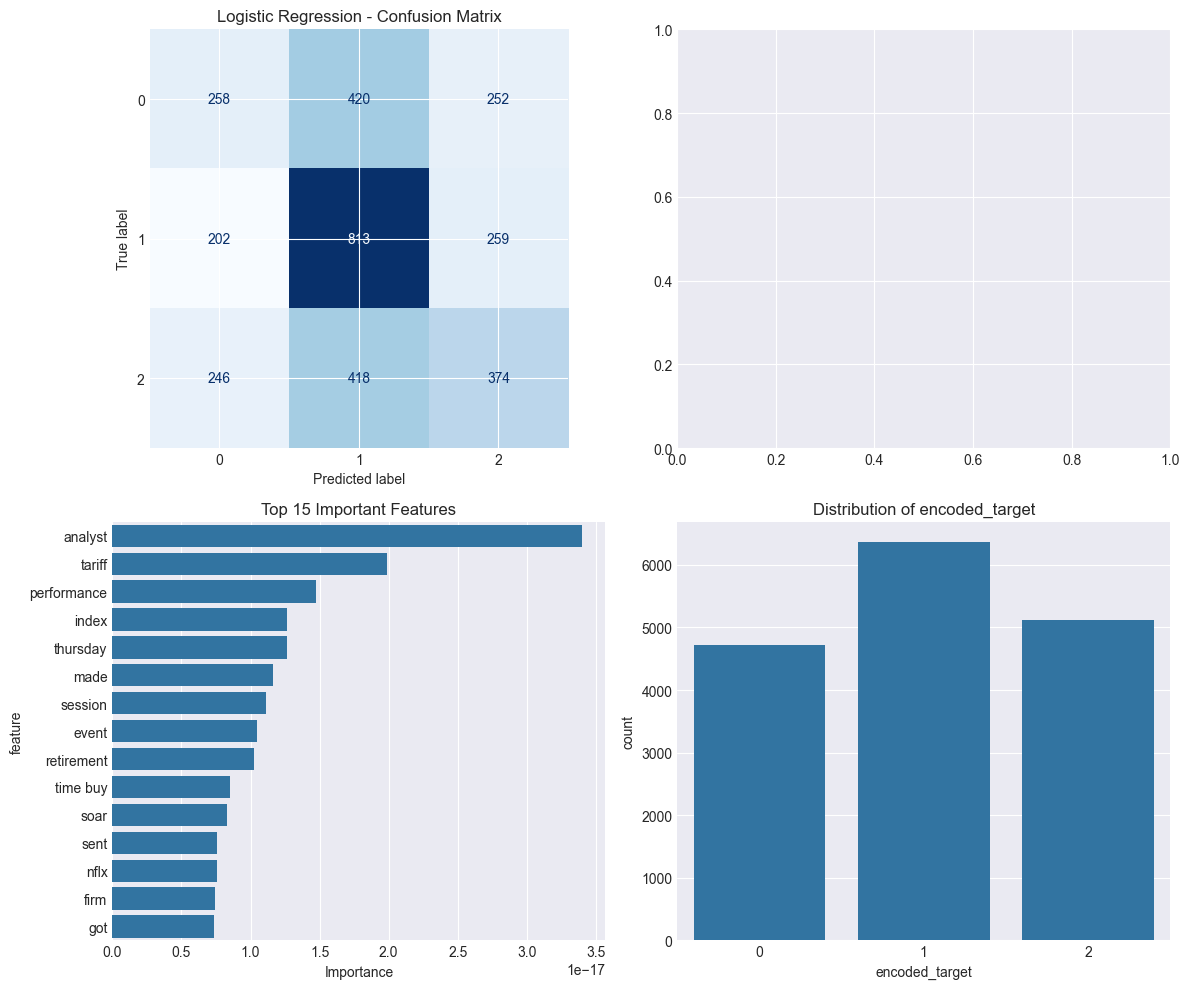

Creating market-based sentiment lexicon using SHAP...
Created sentiment lexicon with 741 words

Top positive words:
         word sentiment     direction  importance
652    tariff  positive  1.990865e-17    0.028334
23    analyst  positive  3.399576e-17    0.015817
670     today  positive  1.317541e-18    0.011850
462      nyse  positive  4.206606e-19    0.010308
95        buy  positive  5.662911e-20    0.009464
168       day  positive  1.244288e-18    0.009053
667  thursday  positive  1.265754e-17    0.008242
156      corp  positive  7.269115e-18    0.007458
167     daily  positive  4.930745e-19    0.007347
438    nasdaq  positive  5.149626e-19    0.006876

Top negative words:
              word sentiment     direction  importance
547        reality  negative -1.179836e-18    0.001039
551     reason buy  negative -1.961229e-18    0.001039
575         rising  negative -9.553821e-19    0.001039
84         brainer  negative -2.913947e-19    0.001038
605          simon  negative -4.344835

In [83]:

# Build model
results = sentiment_model.build_model(X_df, target='encoded_target', test_size=0.2, random_state=42)

# Visualize results
sentiment_model.visualize_results(results)

# Generate lexicon
lexicon = sentiment_model.create_sentiment_lexicon()


fix shap for xbgoost classifier

In [91]:
lexicon

,word,sentiment,direction,importance
652,tariff,positive,1.990865e-17,0.028334
23,analyst,positive,3.399576e-17,0.015817
100,call,negative,-6.552746e-18,0.012295
670,today,positive,1.317541e-18,0.011850
462,nyse,positive,4.206606e-19,0.010308
...,...,...,...,...
483,part,positive,7.588078e-20,0.001009
131,cloud,positive,1.121702e-18,0.001009
317,history,positive,6.811838e-19,0.001006
621,stance,positive,1.204398e-18,0.001006


In [26]:
results["XGBoost Classifier"]

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=0.8,
               colsample_bytree=None, device='cuda', early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=100,
               n_jobs=None, num_parallel_tree=None, ...),
 'accuracy': 0.45033929673041334,
 'class_report': '              precision    recall  f1-score   support\n\n           0       0.38      0.35      0.36       930\n           1       0.50      0.56      0.53      1274\n    

In [93]:
target='encoded_target'
# X_df, data, labelencoder
y = data[target].values
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42
)

model = XGBClassifier(
    n_estimators=100,
    learning_rate=1,
    max_depth=10,
    subsample=0.8,
    colsample_bynode=0.8,
    tree_method='hist',
    device='cuda',
    verbosity=1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [94]:
acc = accuracy_score(y_test, np.round(y_pred))
prec = precision_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
rec = recall_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
f1 = f1_score(y_test, np.round(y_pred), zero_division=0, average='weighted')

# For multiclass ROC/AUC, use probability estimates and specify multi_class
if hasattr(model, "predict_proba"):
	y_proba = model.predict_proba(X_test)
	auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
else:
	auc = None

print(classification_report(y_test, y_pred))
print("acc:",acc)
print("prec:",prec)
print("rec:",rec)
print("f1:",f1)
print("auc:", auc)

              precision    recall  f1-score   support

           0       0.38      0.35      0.36       930
           1       0.50      0.56      0.53      1274
           2       0.44      0.41      0.42      1038

    accuracy                           0.45      3242
   macro avg       0.44      0.44      0.44      3242
weighted avg       0.45      0.45      0.45      3242

acc: 0.45033929673041334
prec: 0.4461850668134733
rec: 0.45033929673041334
f1: 0.4473962525378178
auc: 0.6124654030939868


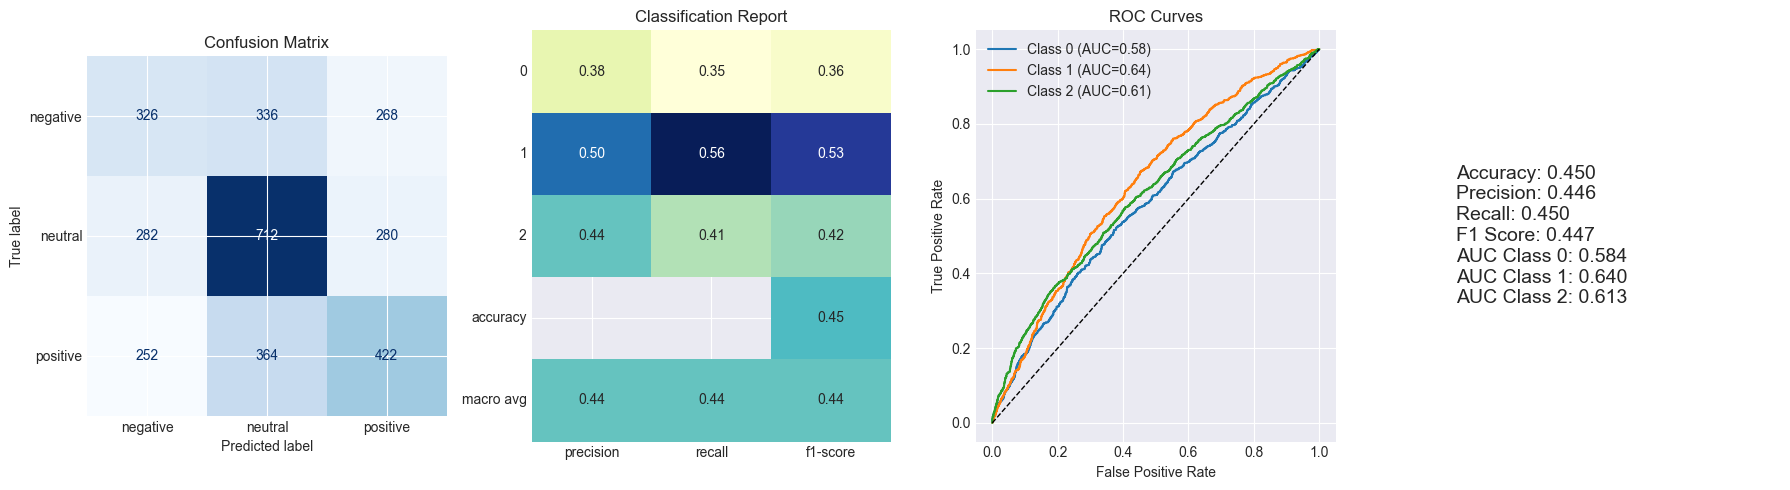

In [95]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import io

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

plt.figure(figsize=(18, 5))

# Compute ROC curve and ROC area for each class
n_classes = len(labelencoder.classes_)
# Binarize the output
y_test_bin = label_binarize(y_test, classes=range(n_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])

# 1. Confusion Matrix
plt.subplot(1, 4, 1)
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labelencoder.classes_, cmap='Blues', colorbar=False, ax=plt.gca())
plt.title("Confusion Matrix")

# 2. Classification Report Table
plt.subplot(1, 4, 2)
# Parse the classification report string into a table

report_df = pd.read_fwf(io.StringIO(class_report), index_col=0)
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="YlGnBu", cbar=False)
plt.title("Classification Report")
plt.yticks(rotation=0)

# 3. ROC Curves for each class
plt.subplot(1, 4, 3)
# Define n_classes based on labelencoder or y_test
n_classes = len(labelencoder.classes_)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC={roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

# 4. Metrics Box
plt.subplot(1, 4, 4)
metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1,
}
metrics.update({f"AUC Class {i}": float(roc_auc[i]) for i in range(n_classes)})
metrics_text = "\n".join([f"{k}: {v:.3f}" for k, v in metrics.items()])
plt.axis('off')
plt.text(0.1, 0.5, metrics_text, fontsize=14, va='center')

plt.tight_layout()
plt.show()

In [96]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
print(explainer, shap_values)

100%|===================| 38784/38904 [04:24<00:00]        

<shap.explainers._tree.TreeExplainer object at 0x000001B0079B1C70> .values =
array([[[ 0.00000000e+00,  0.00000000e+00, -1.40066510e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-1.41170144e-03,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00, -8.82374331e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-5.81752509e-05,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00, -1.40066510e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+

In [97]:
shap_values.values.shape

(12968, 3000, 3)

In [ ]:
print(shap_values.shape) # (12968, 3000, 3)
print((np.abs(shap_values.values).mean(axis=(0, 1))).shape) # (3,)
print(X_df.columns.shape) # (3000,)

(12968, 3000, 3)
(3,)
(3000,)


In [26]:
X_df.columns.shape

(3000,)

In [98]:
(shap_values.values).mean(axis=(0, 2))

array([-2.31200724e-03,  2.32539954e-05, -3.48974983e-05, ...,
        6.69372812e-04,  0.00000000e+00, -1.75381895e-04], shape=(3000,))

In [99]:
shap_values.values.mean(axis=(0, 2))

array([-2.31200724e-03,  2.32539954e-05, -3.48974983e-05, ...,
        6.69372812e-04,  0.00000000e+00, -1.75381895e-04], shape=(3000,))

In [100]:
mean_shap_abs = np.abs(shap_values.values).mean(axis=(0, 2))
mean_shap = (shap_values.values).mean(axis=(0, 2))
feature_names = X_df.columns
if len(mean_shap) != len(feature_names):
    print(f"Mismatch: {len(mean_shap)} shap vs {len(feature_names)} features")
    


feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_shap_abs,
    'direction': mean_shap
}).sort_values(by='importance', ascending=False)

In [102]:
sentiment_dict = {}
for feature, coef, abs_coef in zip(feature_names, mean_shap, mean_shap_abs):
    if abs_coef > 0.002:
        sentiment = 'positive' if coef > 0 else 'negative'
        sentiment_dict[feature] = {
            'sentiment': sentiment,
            'direction': float(coef),
            'importance': float(abs_coef)
        }

lexicon = pd.DataFrame.from_dict(sentiment_dict, orient='index')
lexicon = lexicon.reset_index().rename(columns={'index': 'word'})
lexicon = lexicon.sort_values('importance', ascending=False)

In [77]:
lexicon.shape

(643, 4)

In [103]:
lexicon.sort_values('importance', ascending=False)

,word,sentiment,direction,importance
547,tariff,negative,-0.004453,0.048175
362,nasdaq,negative,-0.002932,0.037742
381,nyse,positive,0.006152,0.031397
620,year,negative,-0.002284,0.028757
569,top,positive,0.004457,0.025735
...,...,...,...,...
36,approach,negative,-0.000103,0.002024
147,different,positive,0.001250,0.002024
580,tv,negative,-0.000381,0.002017
10,adoption,positive,0.000830,0.002012


In [ ]:
plt.figure(figsize=(12, 5))

# Distribution of direction
plt.subplot(1, 2, 1)
sns.histplot(lexicon['direction'], bins=40, kde=True, color='skyblue')
plt.title('Distribution of Lexicon Direction')
plt.xlabel('Direction (Mean SHAP Value)')
plt.ylabel('Frequency')

# Distribution of importance (absolute mean SHAP)
plt.subplot(1, 2, 2)
sns.histplot(lexicon['importance'], bins=40, kde=True, color='salmon')
plt.title('Distribution of Lexicon Importance')
plt.xlabel('Importance (Abs Mean SHAP Value)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [104]:
feature_importance

,feature,importance,direction
2643,tariff,0.048175,-0.004453
1729,nasdaq,0.037742,-0.002932
1818,nyse,0.031397,0.006152
2972,year,0.028757,-0.002284
2720,top,0.025735,0.004457
...,...,...,...
771,disclosed,0.000000,0.000000
1835,occidental,0.000000,0.000000
2904,water,0.000000,0.000000
2905,wave,0.000000,0.000000


In [72]:
sentiment_model.create_sentiment_lexicon()

Creating market-based sentiment lexicon...
Sentiment lexicon creation only implemented for Linear Regression


hyper search xgboost rf

In [ ]:
sentiment_model = MarketSentiment()
X_df, labeled_data = sentiment_model.preprocess_data(complete_df)

Preprocessing data...
Preprocessing text data...
After preprocessing: 15891 articles


In [126]:
len(labeled_data)

15891

In [127]:
target='future_return'

y = labeled_data[target].values
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=472
)

In [ ]:
try:
    print("Training XGBoost (GPU Random Forest)...")
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    xgb_params = {
        'objective': "reg:squarederror",
        'tree_method' : "hist", 
        'device' : "cuda", # GPU acceleration
        'num_parallel_tree': 100,       # Emulate RF
        'subsample': 0.8,
        'colsample_bynode': 0.8,
        'learning_rate': 1,
        'max_depth': 10,
        'verbosity': 1
    }

    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=1)

    y_pred = xgb_model.predict(dtest)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"XGBoost RF - MSE: {mse:.4f}, R²: {r2:.4f}")
    results['XGBoost RF'] = {
        'model': xgb_model,
        'mse': mse,
        'r2': r2,
        'y_test': y_test,
        'y_pred': y_pred
        }
except Exception as e:
    print("XGBoost RF training failed:", e)

XGBoostRFRegressor

In [ ]:
XGBRFRegressor_model = XGBRFRegressor(
    n_estimators=100,
    learning_rate=1,
    max_depth=10,
    subsample=0.8,
    colsample_bynode=0.8,
    tree_method='hist',
    device='cuda',
    verbosity=1
)


XGBRFRegressor_model.fit(X_train, y_train)
y_pred = XGBRFRegressor_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RF - MSE: {mse:.4f}, R²: {r2:.4f}")
results['XGBoost RF'] = {
    'model': XGBRFRegressor_model,
    'mse': mse,
    'r2': r2,
    'y_test': y_test,
    'y_pred': y_pred
}

XGBoost RF - MSE: 21.7214, R²: -0.0344


c:\Users\andre\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:729: UserWarning: [19:21:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


XgboostRegressor

In [25]:
from xgboost import XGBRegressor

xgbregressor_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',     # or 'gpu_hist' if using GPU
    device='cuda',          # if using GPU
    random_state=42
)
xgbregressor_model.fit(X_train, y_train)
y_pred = xgbregressor_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost regressor - MSE: {mse:.4f}, R²: {r2:.4f}")
results['XGBoost regressor'] = {
    'model': xgbregressor_model,
    'mse': mse,
    'r2': r2,
    'y_test': y_test,
    'y_pred': y_pred
}

XGBoost regressor - MSE: 21.9191, R²: -0.0438


In [23]:
XGBRFRegressor_model.feature_importances_

array([0.00453341, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], shape=(3000,), dtype=float32)

{'Linear Regression': {'model': LinearRegression(),
  'mse': 26.231716448313275,
  'r2': -0.27813839031966014,
  'y_test': array([-5.455,  0.445,  3.525, ..., -0.6  ,  0.975, -1.09 ], shape=(3179,)),
  'y_pred': array([ 3.28631045,  2.71024841, -1.55574839, ..., -3.50168246,
         -2.36312546, -2.36546032], shape=(3179,))},
 'XGBoost RF': {'model': XGBRFRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bytree=None, device='cuda',
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, feature_types=None, feature_weights=None,
                 gamma=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=1, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=10, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=No

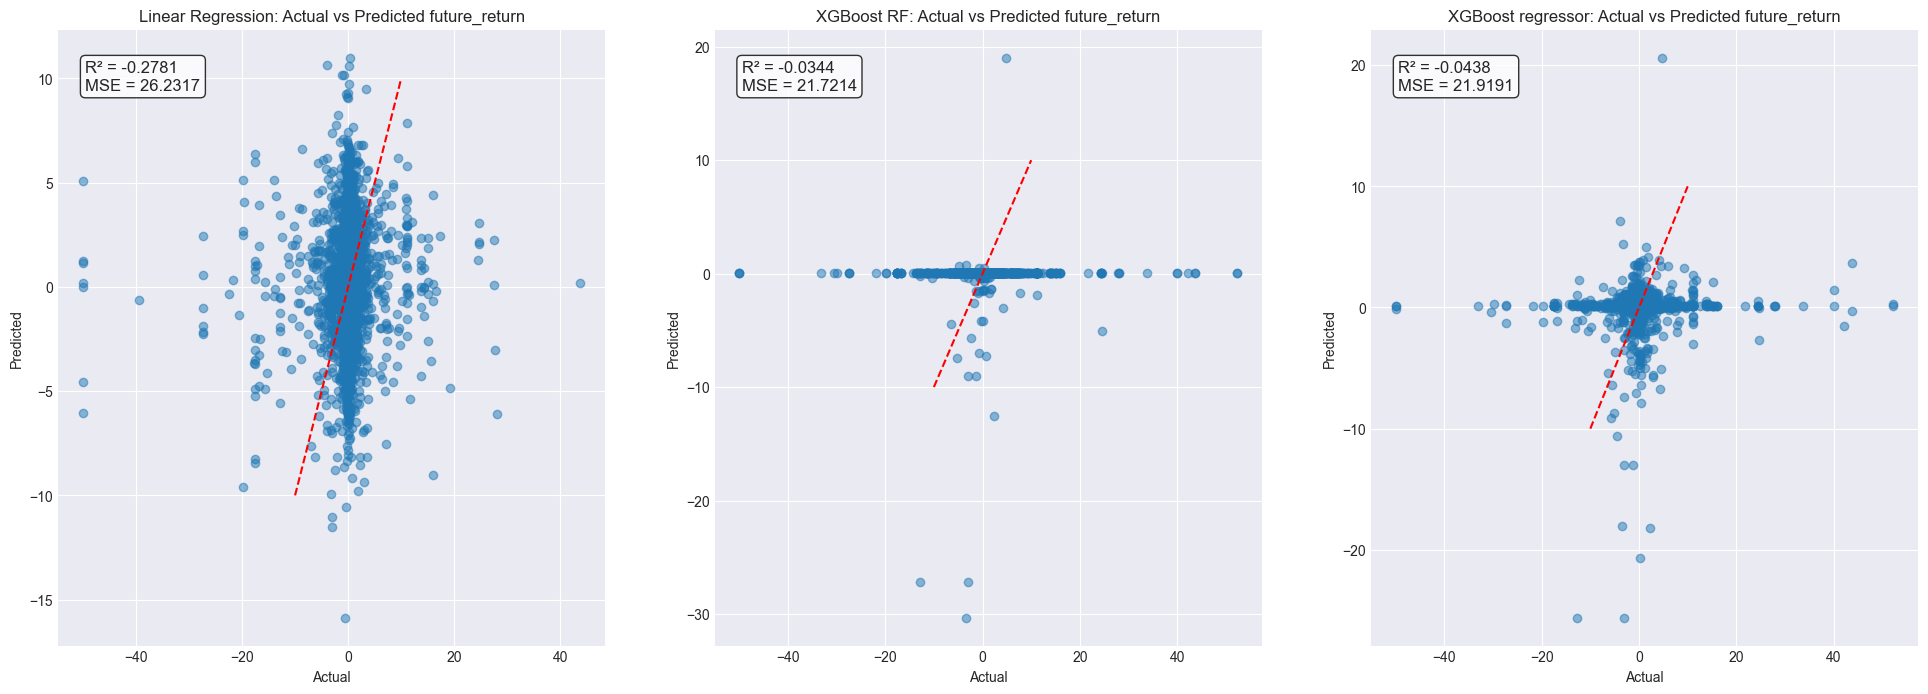

In [40]:
plt.style.use('seaborn-v0_8-darkgrid')
        
# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# 1. Plot actual vs predicted values for each model
for i, (name, result) in enumerate(results.items()):
            ax = axes[i]
            ax.scatter(result['y_test'], result['y_pred'], alpha=0.5)
            ax.plot([-10, 10], [-10, 10], 'r--')  # Perfect prediction line
            ax.set_title(f'{name}: Actual vs Predicted {target}')
            ax.set_xlabel('Actual')
            ax.set_ylabel('Predicted')
            ax.text(0.05, 0.95, f"R² = {result['r2']:.4f}\nMSE = {result['mse']:.4f}", 
                   transform=ax.transAxes, fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

SPlitting into sector wise models

In [150]:
complete_df = get_complete_df(tickers, '+5 hour')

sentiment_model = MarketSentiment()
X_df, labeled_data = sentiment_model.preprocess_data(complete_df)

Fetched 1680 rows for ticker: AAPL
Fetched 1371 rows for ticker: MSFT
Fetched 1375 rows for ticker: NVDA
Fetched 0 rows for ticker: JPM
Fetched 1412 rows for ticker: BAC
Fetched 1376 rows for ticker: GS
Fetched 606 rows for ticker: PLD
Fetched 1285 rows for ticker: O
Fetched 811 rows for ticker: SPG
Fetched 2822 rows for ticker: XOM
Fetched 2851 rows for ticker: CVX
Fetched 1908 rows for ticker: SLB
Fetched 1395 rows for ticker: AMZN
Fetched 1395 rows for ticker: WMT
Fetched 1429 rows for ticker: TGT
Fetched 1411 rows for ticker: KO
Fetched 1384 rows for ticker: PG
Fetched 1417 rows for ticker: PEP
Fetched 1343 rows for ticker: JNJ
Fetched 1385 rows for ticker: PFE
Fetched 1437 rows for ticker: NFLX
Fetched 1170 rows for ticker: DIS
Fetched 0 rows for ticker: CMCSA
Final DataFrame columns: Index(['ticker', 'url', 'title', 'summary', 'source_domain',
       'closest_time_before_published', 'future_time', 'adjusted_future_time',
       'open_price', 'future_price', 'time_published'],
   

In [151]:
# get sectors for each ticker
tickers_sector = pd.read_sql_query("""
                        SELECT 
                            ticker,
                            sector
                        FROM Stocks
                        """, conn)
                        
tickers_sector.head(10)

,ticker,sector
0,AAPL,Technology
1,MSFT,Technology
2,NVDA,Technology
3,JPM,Financials
4,BAC,Financials
5,GS,Financials
6,PLD,Real Estate
7,O,Real Estate
8,SPG,Real Estate
9,XOM,Energy


In [152]:
# Merge sectors onto labeled_data using the ticker column
labeled_data = labeled_data.merge(tickers_sector, on='ticker', how='left')

In [153]:
len(labeled_data)

6800

In [154]:
sectors = labeled_data['sector'].unique()
print(sectors)

['Technology' 'Financials' 'Real Estate' 'Energy' 'E-commerce / Retail'
 'Foods and Consumables' 'Healthcare' 'Entertainment']


using onlt XGB regressor test model on seperate sectors

In [155]:
labeled_data.head(1)

,ticker,url,title,summary,source_domain,closest_time_before_published,future_time,adjusted_future_time,open_price,future_price,time_published,text,future_return,cleaned_text,sector
0,AAPL,https://www.marketwatch.com/story/apple-card-s...,Apple Card savings account has an attractive 4...,The tech giant recently debuted a new savings ...,www.marketwatch.com,2023-05-02 18:20:00+00:00,2023-05-02 23:20:00,2023-05-03 13:30:00,168.64,170.26,20230502T182500,Apple Card savings account has an attractive 4...,1.62,apple card saving account attractive interest ...,Technology


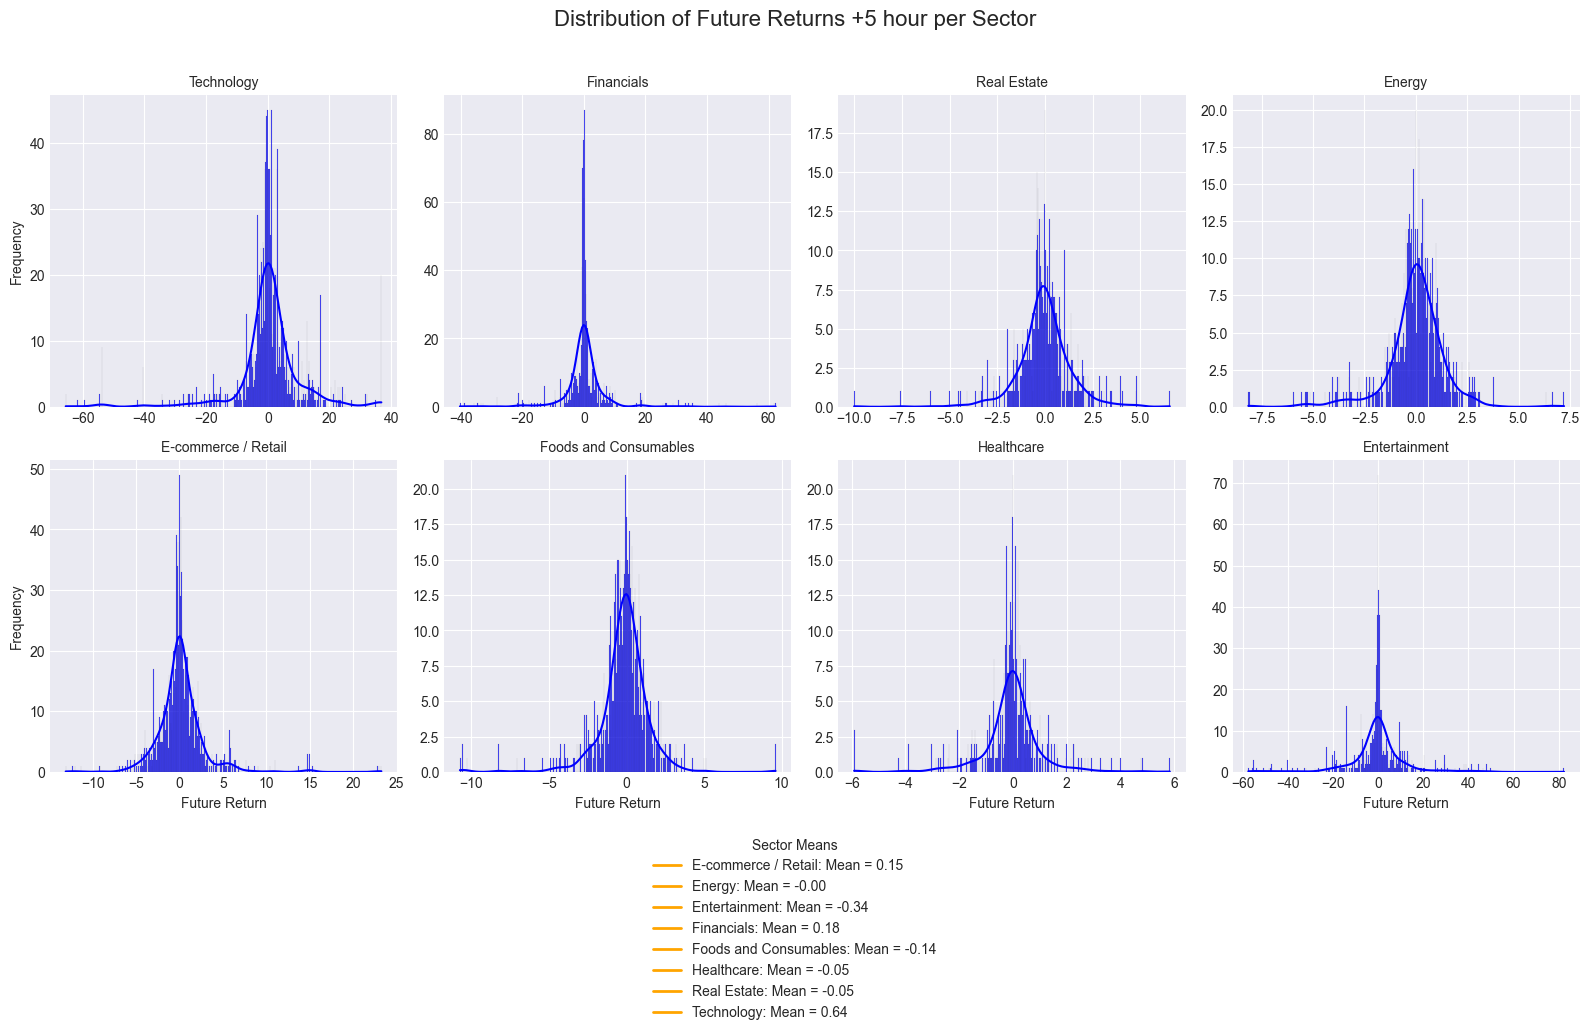

In [156]:
import seaborn as sns

import matplotlib.pyplot as plt

sector_means = labeled_data.groupby('sector')['future_return'].mean()
# Set up the FacetGrid
g = sns.FacetGrid(labeled_data, col="sector", col_wrap=4, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "future_return", kde=True, bins=500, color="blue", alpha=0.7)

# Add titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Future Return", "Frequency")
g.fig.suptitle("Distribution of Future Returns +5 hour per Sector", fontsize=16, y=1.02)

# Add a custom legend with the mean values
handles = [plt.Line2D([0], [0], color='orange', lw=2, label=f"{sector}: Mean = {mean:.2f}") 
           for sector, mean in sector_means.items()]
g.fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=1, title="Sector Means")


plt.tight_layout()
plt.show()

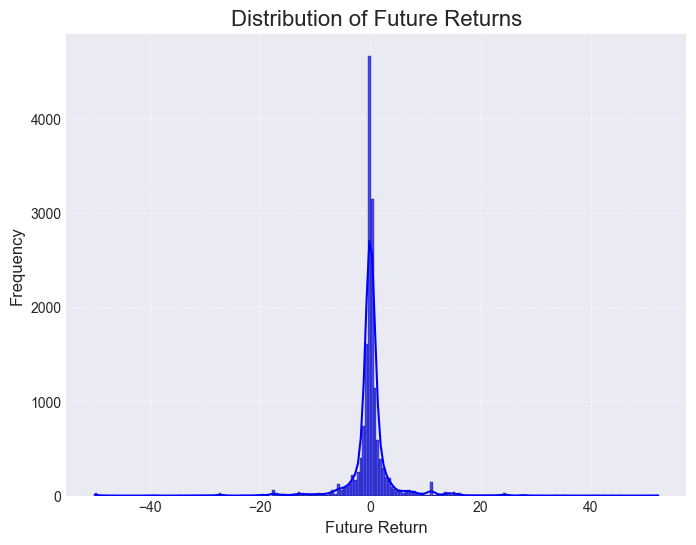

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(labeled_data['future_return'], kde=True, bins=200, color='blue', alpha=0.7)
plt.title('Distribution of Future Returns 1+ hour', fontsize=16)
plt.xlabel('Future Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [143]:
from xgboost import XGBRegressor

sector_results = {}

for sector in sectors:
    print(sector)
    # Filter the data for the current sector
    sector_data = labeled_data[labeled_data['sector'] == sector]
    
    # Check if there are enough samples in the sector
    if len(sector_data) < 10:
        print(f"Not enough data for sector {sector}. Skipping...")
        continue

    # Preprocess the data
    X_df, y_data = sentiment_model.preprocess_data(sector_data)

    # Split the data
    y = y_data[target].values
    X_train, X_test, y_train, y_test = train_test_split(
        X_df, y, test_size=0.2, random_state=472
    )
    xgbregressor_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',     # or 'gpu_hist' if using GPU
        device='cuda',          # if using GPU
        random_state=42
    )
    xgbregressor_model.fit(X_train, y_train)
    y_pred = xgbregressor_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"XGBoost regressor for {sector} - MSE: {mse:.4f}, R²: {r2:.4f}")
    sector_results[f'XGBoost regressor for {sector}'] = {
        'model': xgbregressor_model,
        'mse': mse,
        'r2': r2,
        'y_test': y_test,
        'y_pred': y_pred,
        'sector': sector,
        'feature_importances': xgbregressor_model.feature_importances_
    }

Technology
Preprocessing data...
Preprocessing text data...
After preprocessing: 3164 articles
XGBoost regressor for Technology - MSE: 31.8768, R²: -0.0693
Financials
Preprocessing data...
Preprocessing text data...
After preprocessing: 2006 articles
XGBoost regressor for Financials - MSE: 43.1351, R²: -0.2101
Real Estate
Preprocessing data...
Preprocessing text data...
After preprocessing: 1236 articles
XGBoost regressor for Real Estate - MSE: 1.3817, R²: -0.4150
Energy
Preprocessing data...
Preprocessing text data...
After preprocessing: 1839 articles
XGBoost regressor for Energy - MSE: 1.1010, R²: -0.0720
E-commerce / Retail
Preprocessing data...
Preprocessing text data...
After preprocessing: 2759 articles
XGBoost regressor for E-commerce / Retail - MSE: 5.2239, R²: -0.3242
Foods and Consumables
Preprocessing data...
Preprocessing text data...
After preprocessing: 2003 articles
XGBoost regressor for Foods and Consumables - MSE: 1.4632, R²: -0.0343
Healthcare
Preprocessing data...
P

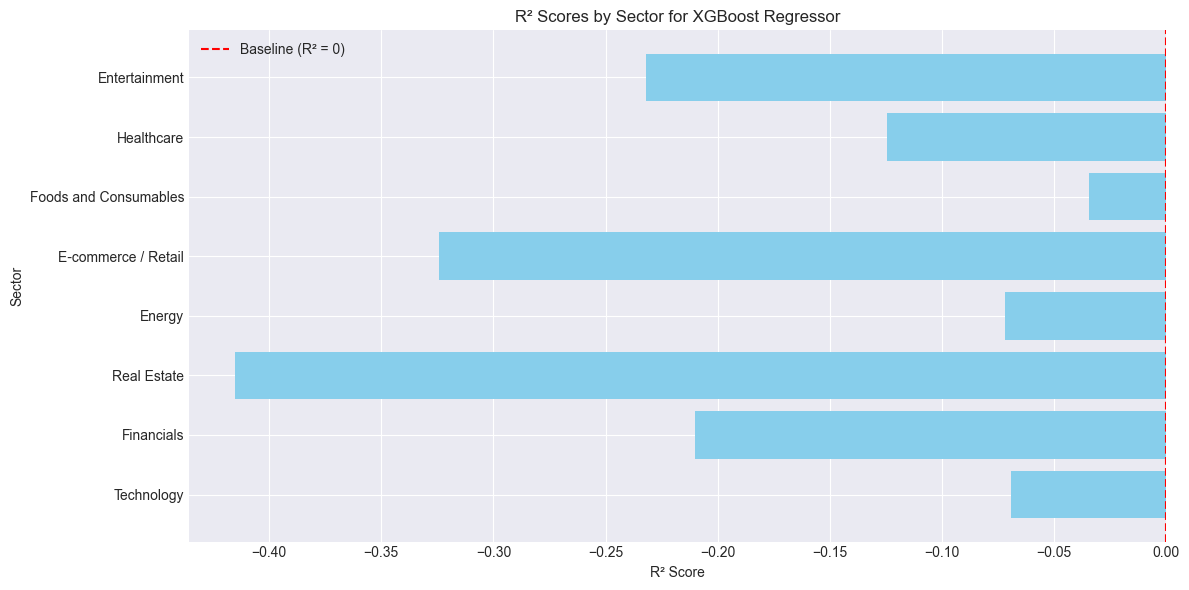

In [144]:
# Extract sector names and R² scores
sector_names = [result['sector'] for result in sector_results.values()]
r2_scores = [result['r2'] for result in sector_results.values()]

# Plot the R² scores for each sector
plt.figure(figsize=(12, 6))
plt.barh(sector_names, r2_scores, color='skyblue')
plt.xlabel('R² Score')
plt.ylabel('Sector')
plt.title('R² Scores by Sector for XGBoost Regressor')
plt.axvline(0, color='red', linestyle='--', label='Baseline (R² = 0)')
plt.legend()
plt.tight_layout()
plt.show()

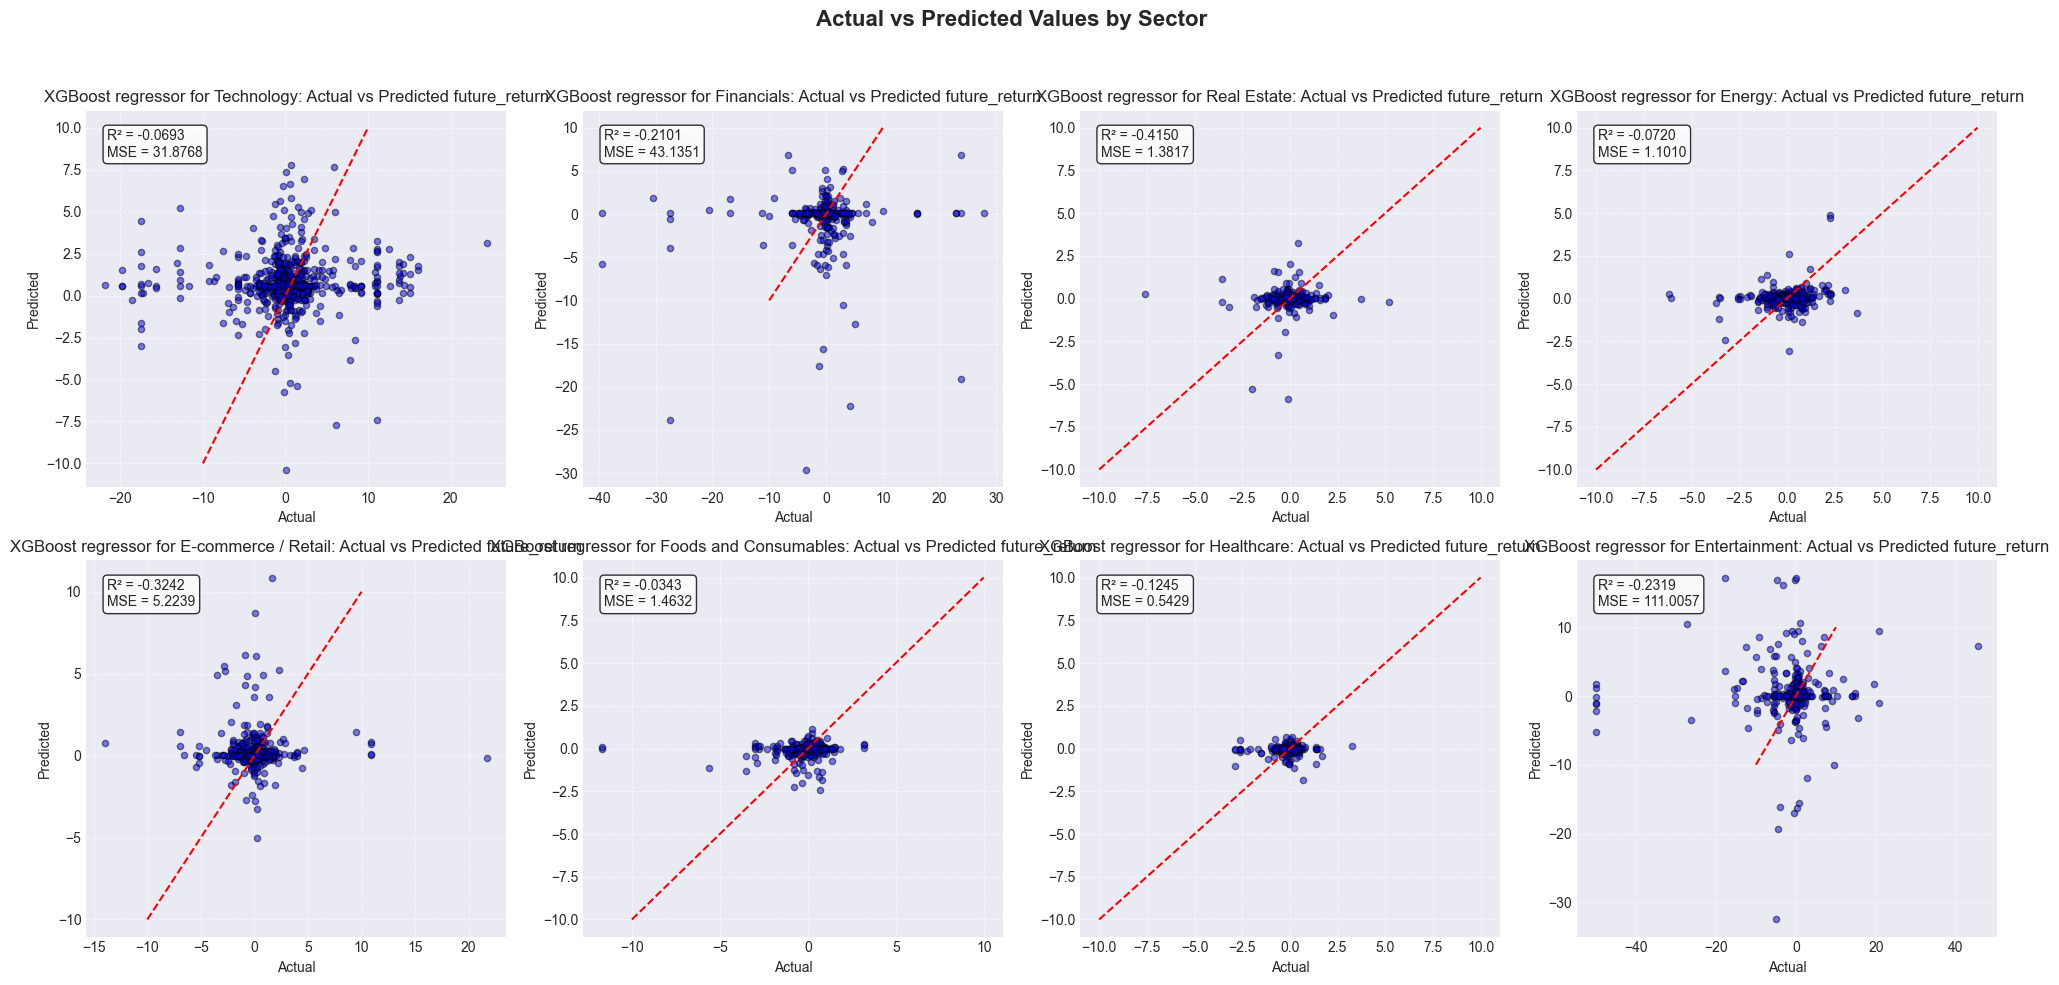

In [145]:
plt.style.use('seaborn-v0_8-darkgrid')

# Create figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjusted figure size for better spacing

# Flatten the axes array for easier indexing
axes = axes.flatten()

# 1. Plot actual vs predicted values for each model
for i, (name, result) in enumerate(sector_results.items()):
    ax = axes[i]
    ax.scatter(result['y_test'], result['y_pred'], alpha=0.5, color='blue', edgecolor='k', s=20)
    ax.plot([-10, 10], [-10, 10], 'r--', linewidth=1.5)  # Perfect prediction line
    ax.set_title(f'{name}: Actual vs Predicted {target}', fontsize=12)
    ax.set_xlabel('Actual', fontsize=10)
    ax.set_ylabel('Predicted', fontsize=10)
    ax.text(0.05, 0.95, f"R² = {result['r2']:.4f}\nMSE = {result['mse']:.4f}", 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.grid(True, linestyle='--', alpha=0.6)

# Hide unused subplots if sector_results has fewer than 8 items
for j in range(len(sector_results), len(axes)):
    fig.delaxes(axes[j])

# Add a main title for the entire figure
fig.suptitle('Actual vs Predicted Values by Sector', fontsize=16, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()